# DATA ANALYSIS Notebook

### Library import, global variables and pre-processing

In [255]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [256]:
# Adjusting default formatting settings

uni_font = 'Helvetica'
uni_fontsize = 7
uni_color = 'black'
hfont = {'fontname':uni_font}
mm = 1/(2.54*10)  # millimeters in inches
# typical paper widths: one-column 89mm, two-column 183mm

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.major.width'] = 0.8

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['ytick.major.width'] = 0.8

In [257]:
# Constant Variables

cbe_comfort_colors = ['#95b3df', '#acdef7','#d4eefb', '#d9eacc', '#f9cbd4', '#f2907f', '#c36a6a']
cbe_satisfaction_colors = ['#bc3e4d','#d57061','#d99fa8','#f3e8e7','#c1e0b9' ,'#84c286','#38a257']

In [258]:
# Importing processed datasets

field_data = pd.read_csv('data/input/field_data.csv')
metadata = pd.read_csv('data/input/metadata.csv')
ashrae = pd.read_csv('data/input/ashrae.csv')
ashrae_subset = pd.read_csv('data/input/ashrae_personal_subset.csv')

/Users/tobi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [259]:
# Creating subsets of ASHRAE data

ashrae_australia = ashrae.loc[ashrae['country'] == 'australia'].reset_index(drop=True)

ashrae_climate = ashrae.loc[ashrae['climate'].str.contains('subtropical')].reset_index(drop=True)

ashrae_brisbane = ashrae.loc[ashrae['city'] == 'brisbane'].reset_index(drop=True)

# * This would be the ASHRAE dataset if duplication is avoided completely
# ashrae = ashrae.loc[(ashrae['country'] != 'australia') & (~ashrae['climate'].str.contains('subtropical'))].reset_index(drop=True)

In [260]:
# Dropping redundant columns

# there is only one entry for TSV = 3, not representative
field_data = field_data.loc[field_data['thermal_sensation'] != 3]

In [261]:
# Merging field with off-boarding data

metadata['metadata'] = 'True'

field_data = field_data.merge(metadata, on='subject_id', how="left")

field_data.to_pickle('data/interim/field-meta.pkl')

In [262]:
# MAIN DATASETS

datasets = (ashrae, ashrae_climate, ashrae_australia, ashrae_brisbane, field_data)
names = ('ASHRAE', 'CLIMATE ZONE', 'AUSTRALIA', 'BRISBANE', 'field_data')

for i in range(0,len(datasets)):
    print(names[i] + " - " + str(len(datasets[i])))

ASHRAE - 109033
CLIMATE ZONE - 18490
AUSTRALIA - 8002
BRISBANE - 1174
field_data - 812


In [263]:
# PARAMETER GROUPS

# intersection
common_variables = list(set(ashrae.columns).intersection(field_data.columns))
common_variables.sort()

# difference
additional_variables = list(set(field_data.columns).difference(ashrae.columns))
additional_variables.sort()

# Custom VARIABLE GROUPS
target = ['thermal_preference', 'thermal_sensation', 'thermal_acceptability', 'thermal_sensation_3point']
personal = ['age', 'age_group', 'clo','gender', 'met']
metrics = ['pmv', 'set']
environmental = ['ta', 'tg', 'top', 'tr', 'vel', 'rh', 'season', 't_out_mean', 'running_mean_t_out', 'rh_out_mean', 'building_id' ]
control = ['blind_curtain','door', 'heater', 'window']
contextual = list(metadata.columns)

custom_ashrae = ['fan']

# A. Data Analysis

## A.1 - descriptive features

In [264]:
# Description numerical columns

field_data.describe().T.tail(40)

,count,mean,std,min,25%,50%,75%,max
rh_out_9am,812.0,69.383005,12.665471,38.000000,60.000000,65.000000,76.000000,94.000000
t_out_mean,812.0,23.758251,3.204813,16.500000,20.570000,23.270000,26.000000,29.470000
rh_out_mean,812.0,63.127463,11.485989,44.500000,56.000000,60.000000,69.500000,92.500000
running_mean_t_out,812.0,24.371675,3.577324,16.800000,20.200000,25.800000,27.300000,28.200000
utci_am,812.0,18.106897,7.923329,1.200000,10.700000,21.800000,23.100000,29.200000
utci_pm,812.0,21.454064,4.965970,7.200000,20.100000,21.600000,24.900000,29.900000
tr,812.0,23.588818,1.287571,15.450000,22.830000,23.635000,24.352500,27.120000
top,812.0,23.600480,1.148709,18.740000,22.917500,23.650000,24.222500,27.010000
vel_r,812.0,0.179926,0.158321,0.000000,0.050000,0.140000,0.250000,0.810000
pmv,809.0,0.057676,0.632780,-1.730000,-0.360000,0.050000,0.480000,2.000000


In [265]:
# Description categorical columns

field_data.describe(include=object).T

,count,unique,top,freq
time,812,789,2021-11-04 09:25:00,3
season,812,2,winter,407
gender,812,2,female,525
age_group,812,5,25 - 34,398
city,812,1,brisbane,812
country,812,1,australia,812
climate,812,1,humid subtropical,812
cooling_type,812,1,air conditioned,812
building_type,812,1,office,812
origin,678,6,australia,307


### Weather

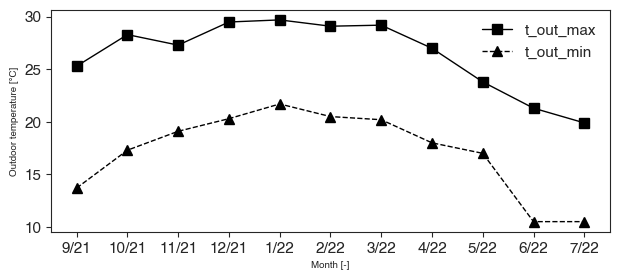

In [266]:
# Mean Outdoor Temperatures

weather = pd.read_csv('data/input/weather.csv')

maximums = weather.groupby('month-date', sort=False)['t_out_max'].mean().round(decimals=1).reset_index(name='max')
minimums = weather.groupby('month-date', sort=False)['t_out_min'].mean().round(decimals=1).reset_index(name='min')

table = maximums.merge(minimums, on='month-date', how='left')

width = 183*mm
plt.figure(figsize=(width,0.4*width), dpi=100)

plt.plot(table['max'], marker='s', markersize=7, ls='solid', color=uni_color, linewidth=1)
plt.plot(table['min'],marker='^', markersize=7, ls='dashed', color=uni_color, linewidth=1)

plt.xticks(range(0,11,1),labels=table['month-date'])
plt.ylabel('Outdoor temperature [°C]', size=uni_fontsize, font=uni_font)
plt.xlabel('Month [-]', size=uni_fontsize, font=uni_font)

plt.legend(labels=['t_out_max','t_out_min'], frameon=False)

# plt.savefig('reports/figures/outdoor_temperatures.png',bbox_inches = 'tight',dpi=600, transparent=True)

plt.show()


### data samples / subject

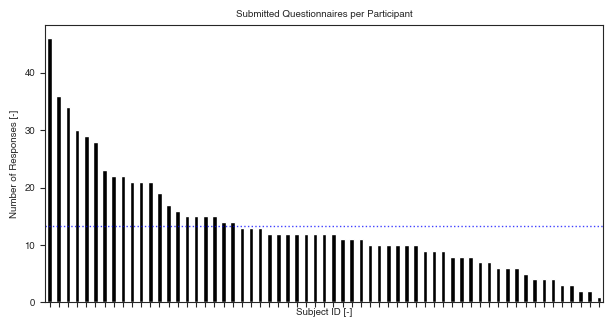

In [267]:
# SUBJECT ID / SURVEY COUNT

width = 183*mm

plt.figure(figsize=(width,0.5*width), dpi=100)
field_data.subject_id.value_counts().plot.bar(color=uni_color)

plt.xlabel('Subject ID [-]', size=uni_fontsize, font=uni_font)
plt.ylabel('Number of Responses [-]', size=uni_fontsize, font=uni_font)

plt.yticks(fontsize=uni_fontsize, font=uni_font)
plt.xticks(fontsize=uni_fontsize, font=uni_font)
plt.tick_params(labelbottom = False)
plt.axhline(field_data.subject_id.value_counts().mean(), color='blue', linewidth=1, ls='dotted', label='mean', alpha=0.75)

plt.title('Submitted Questionnaires per Participant', fontsize=uni_fontsize, font=uni_font)
# plt.savefig('reports/figures/survey_count.png',bbox_inches = 'tight',dpi=600, transparent=True)

plt.show()

### age

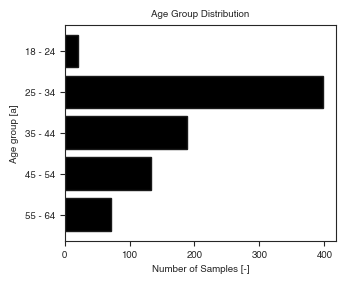

25 - 34    398
35 - 44    189
45 - 54    133
55 - 64     72
18 - 24     20
Name: age_group, dtype: int64

In [268]:
# AGE DISTRIBUTION
width = 89*mm
plt.figure(figsize=(width, 0.8*width), dpi=100)

# sixties = field_data.loc[field_data['age_group'] == '65 - 74'].count()[0]
fifties = field_data.loc[field_data['age_group'] == '55 - 64'].count()[0]
forties = field_data.loc[field_data['age_group'] == '45 - 54'].count()[0]
thirties = field_data.loc[field_data['age_group'] == '35 - 44'].count()[0]
twennies  = field_data.loc[field_data['age_group'] == '25 - 34'].count()[0]
teens = field_data.loc[field_data['age_group'] == '18 - 24'].count()[0]

labels = ['55 - 64','45 - 54','35 - 44','25 - 34','18 - 24']
values = [fifties,forties,thirties,twennies,teens]
plt.barh(labels,values,color=uni_color,edgecolor='k')

plt.xlabel('Number of Samples [-]', size=uni_fontsize, font=uni_font)
plt.ylabel('Age group [a]', size=uni_fontsize, font=uni_font)

plt.yticks(fontsize=uni_fontsize, font=uni_font)
plt.xticks(fontsize=uni_fontsize, font=uni_font)

plt.title('Age Group Distribution', fontsize=uni_fontsize, font=uni_font)

# plt.savefig('reports/figures/age_group_distribution.png',bbox_inches = 'tight',dpi=600, transparent=True)
plt.show()

field_data.age_group.value_counts()


### gender

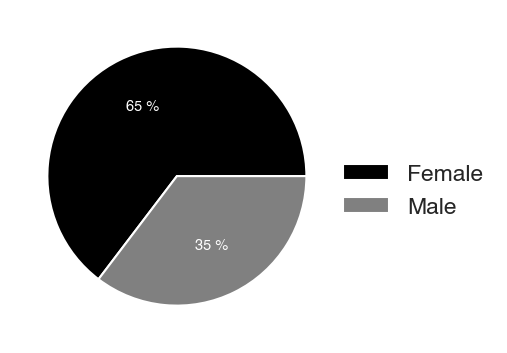

female    525
male      287
Name: gender, dtype: int64

In [269]:
# SEX DISTRIBUTION

width = 89*mm

plt.figure(figsize=(width,0.8*width), dpi=150)

female = field_data.loc[field_data['gender'] == 'female'].count()[0]
male  = field_data.loc[field_data['gender'] == 'male'].count()[0]

labels = ['Female', 'Male']
colors = [uni_color,'grey']

plt.pie([female, male], labels=None, colors=colors, textprops=dict(font=uni_font, color='white'), autopct='%.f %%')
plt.legend(labels=labels,loc="best", bbox_to_anchor = [0.95, 0.6], frameon=False, prop={'family':uni_font} )

# plt.savefig('reports/figures/gender_distribution.png',bbox_inches = 'tight',dpi=600, transparent=True)

plt.show()

field_data.gender.value_counts()

## A.2 - TARGETS

### thermal preference

In [270]:
# CALCULATE IQR TO FILTER COMPARISON DATA

col = 'ta'

Q3 = np.quantile(field_data[col], 0.75)
Q1 = np.quantile(field_data[col], 0.25)
IQR = Q3 - Q1

lower_range = Q1 - 1 * IQR
upper_range = Q3 + 1 * IQR

print(Q1,Q3,lower_range,upper_range)

22.7175 24.2025 21.2325 25.6875


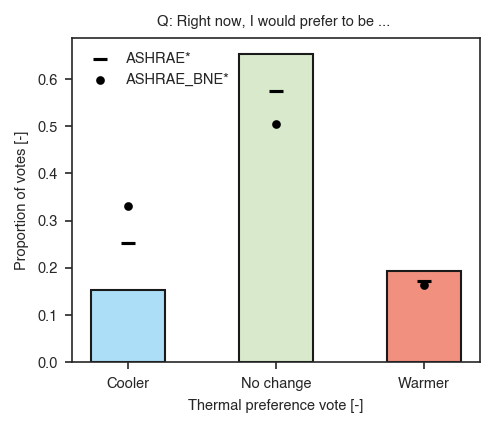

In [271]:
# HISTOGRAM TPV

width = 89*mm

plt.figure(figsize=(width,0.8*width), dpi=150)

labels = ['Cooler','No change','Warmer']

div = len(field_data)
cooler = field_data.loc[field_data['thermal_preference'] == -1].count()[0]
neutral  = field_data.loc[field_data['thermal_preference'] == 0].count()[0]
warmer = field_data.loc[field_data['thermal_preference'] == 1].count()[0]

plt.bar([-1, 0, 1],
        edgecolor = 'k',
        width=0.5,
        height=[cooler/div,neutral/div,warmer/div],
        color=[cbe_comfort_colors[1],cbe_comfort_colors[3],cbe_comfort_colors[5]],
        tick_label=labels)

plt.title('Q: Right now, I would prefer to be ... ', size=uni_fontsize, **hfont);
plt.ylabel('Proportion of votes [-]', size=uni_fontsize, **hfont);
plt.xlabel('Thermal preference vote [-]', size=uni_fontsize, **hfont);


plt.yticks(fontsize=uni_fontsize, **hfont)
plt.xticks(range(-1,2,1),labels=labels, fontsize=uni_fontsize, **hfont)


# for comparison -------------
# ASHRAE complete
total_data = ashrae.loc[ashrae.ta.between(21.2,25.7, inclusive='both')]
data = total_data['thermal_preference'].value_counts().div(len(total_data['thermal_preference'].dropna()), axis=0).reset_index(name='tp')
fig = plt.scatter(data['index'],data.tp,
            marker='_',
            s=50,
            color='black', 
            zorder=10)

# ASHRAE Brisbane
bne_data = ashrae_brisbane.loc[ashrae_brisbane.ta.between(21.2,25.7, inclusive='both')]
data = bne_data['thermal_preference'].value_counts().div(len(bne_data['thermal_preference'].dropna()), axis=0).reset_index(name='tp')
fig2 = plt.scatter(data['index'],data.tp,
            marker='o',
            s=10,
            color='black', 
            zorder=10)
#-----------------------------


plt.legend(handles=[fig, fig2],
            labels=['ASHRAE*','ASHRAE_BNE*'],
            loc= 'upper left',
            fontsize=7,
            frameon=False)

# plt.savefig('reports/figures/thermal-preference-distribution.png',dpi=300,bbox_inches = 'tight', transparent=True)
plt.show()


In [272]:
field_data['thermal_preference'].value_counts()

 0    531
 1    157
-1    124
Name: thermal_preference, dtype: int64

### thermal sensation

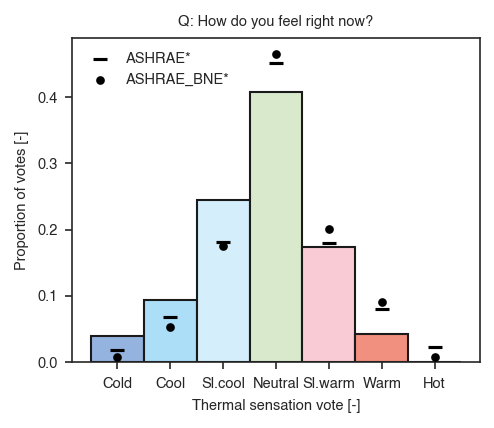

In [273]:
# HISTOGRAM TSV
width = 89*mm

plt.figure(figsize=(width,0.8*width), dpi=150)

bins = [-3.5,-2.5, -1.5, -0.5, 0.5, 1.5, 2.5,3.5]
hfont = {'fontname':uni_font}


# Plot histogram.
n, bins, patches = plt.hist(field_data['thermal_sensation'].dropna(),
                    weights=np.ones(len(field_data)) / len(field_data),
                    bins=bins, edgecolor = 'k')

bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(range(0,len(col)), patches):
    plt.setp(p, 'facecolor', cbe_comfort_colors[c])
    

labels = ['Cold','Cool','Sl.cool','Neutral','Sl.warm','Warm','Hot']
ticks = [-3,-2,-1,0,1,2,3]


plt.ylabel('Proportion of votes [-]', size=uni_fontsize, **hfont)
plt.xlabel('Thermal sensation vote [-]', size=uni_fontsize, **hfont);

plt.title('Q: How do you feel right now?', size=uni_fontsize, **hfont);
plt.yticks(fontsize=uni_fontsize, **hfont)
plt.xticks(ticks=ticks,labels=labels, fontsize=uni_fontsize, **hfont)

# for comparison -------------
# ASHRAE complete
total_data = ashrae.loc[ashrae.ta.between(21.2,25.7, inclusive='both')]
data = total_data['thermal_sensation'].round().value_counts().div(len(total_data['thermal_sensation'].dropna()), axis=0).reset_index(name='tsv')
fig = plt.scatter(data['index'],data.tsv,
            marker='_',
            s=50,
            color='black', 
            zorder=10)

# ASHRAE Brisbane
bne_data = ashrae_brisbane.loc[ashrae_brisbane.ta.between(21.2,25.7, inclusive='both')]
data = bne_data['thermal_sensation'].round().value_counts().div(len(bne_data['thermal_sensation'].dropna()), axis=0).reset_index(name='tsv')
fig2 = plt.scatter(data['index'],data.tsv,
            marker='o',
            s=10,
            color='black', 
            zorder=10)
            
#-----------------------------

plt.legend(handles=[fig, fig2],
            labels=['ASHRAE*', 'ASHRAE_BNE*'],
            loc= 'upper left',
            fontsize=7,
            frameon=False)

# plt.savefig('reports/figures/tsv-distribution.png',dpi=300,bbox_inches = 'tight', transparent=True)
plt.show()

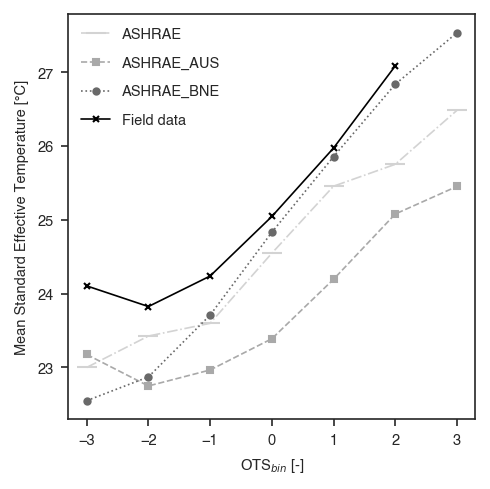

In [274]:
# THERMAL SENSATION VS SET & SUBSETS

df_one = ashrae
df_two = ashrae_australia
df_three = ashrae_brisbane
df_four = field_data

# df_one['t_diff'] = df_one['t_out_mean'] - df_one['top']
# df_two['t_diff'] = df_two['t_out_mean'] - df_two['top']

df_one = df_one.groupby('thermal_sensation_class')['set'].mean().reset_index(name='count')
df_two = df_two.groupby('thermal_sensation_class')['set'].mean().reset_index(name='count')
df_three = df_three.groupby('thermal_sensation_class')['set'].mean().reset_index(name='count')
df_four = df_four.groupby('thermal_sensation')['set'].mean().reset_index(name='count')

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.major.width'] = 0.8

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['ytick.major.width'] = 0.8

# Create plot

width = 89*mm

plt.figure(figsize=(width,width), dpi=150)

plt.errorbar(df_one['thermal_sensation_class'],df_one['count'], fmt='-._',markersize=10, color='lightgrey',linewidth=0.8)
plt.errorbar(df_two['thermal_sensation_class'],df_two['count'], fmt='--s',markersize=3,color='darkgrey',linewidth=0.8)
plt.errorbar(df_three['thermal_sensation_class'],df_three['count'], fmt=':o', markersize=3,color='dimgrey',linewidth=0.8)
plt.errorbar(df_four['thermal_sensation'],df_four['count'], fmt='-x',markersize=3, color='black', linewidth=0.8)


plt.ylabel('Mean Standard Effective Temperature [°C]', size=uni_fontsize, **hfont)
plt.xlabel('OTS$_{bin}$ [-]', size=uni_fontsize, **hfont)

labels=['Cold', 'Cool', 'Slightly cool', 'Neutral', 'Slightly warm', 'Warm', 'Hot']

plt.yticks(fontsize=uni_fontsize, **hfont)
plt.xticks(range(-3,4,1), fontsize=uni_fontsize, **hfont)

plt.legend(labels=['ASHRAE','ASHRAE_AUS','ASHRAE_BNE','Field data'],labelspacing=1, fontsize=uni_fontsize, frameon=False, loc='upper left')

# plt.savefig('reports/figures/tsv-set-dataset-comparison.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()


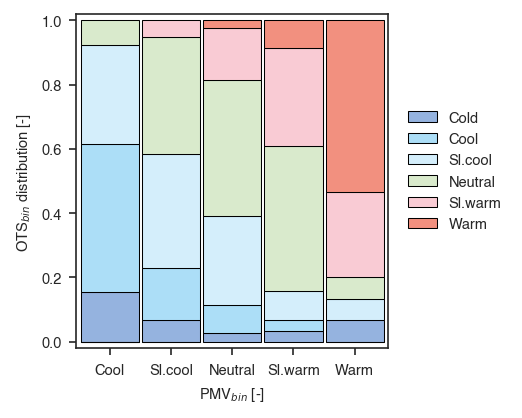

In [275]:
# PMV bin vs TSV bin

width = 89*mm

plt.figure(figsize=(width,0.8*width), dpi=150)

labels = ['Cold', 'Cool', 'Sl.cool', 'Neutral','Sl.warm','Warm','Hot']
data = pd.crosstab(field_data['thermal_sensation'],field_data['pmv_7point']).T

data = data.div(data.sum(axis=1), axis=0)


# ! activate before printing for thinner lines
# plt.rcParams['axes.linewidth'] = 0.5
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['xtick.major.size'] = 3
# plt.rcParams['xtick.major.width'] = 0.5

# plt.rcParams['ytick.left'] = True
# plt.rcParams['ytick.major.size'] = 3
# plt.rcParams['ytick.major.width'] = 0.5

data.plot(
    kind = 'bar',
    edgecolor = 'black',
    linewidth=0.5,
    width = 0.95,
    stacked = True,
    mark_right = True,
    color = cbe_comfort_colors,
    bottom = 0.0,
    ax = plt.gca() )

plt.ylabel("OTS$_{bin}$ distribution [-]", fontsize=uni_fontsize)

plt.xlabel("PMV$_{bin}$ [-]", fontsize=uni_fontsize)
plt.yticks(fontsize=uni_fontsize)
plt.ylim(-0.02,1.02)

plt.xticks(ticks=range(0,5,1), labels=['Cool','Sl.cool','Neutral','Sl.warm','Warm'],rotation=0, fontsize=uni_fontsize)
plt.xlim((-0.55,4.55))


plt.legend(bbox_to_anchor=(1.02, 0.75), labels=labels, frameon=False, fontsize=uni_fontsize)
plt.tight_layout()

# plt.savefig('reports/figures/pmv-tsv-binned-comparison.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()



In [276]:
# RESET STANDARD PARAMETERS

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.major.width'] = 0.8

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['ytick.major.width'] = 0.8

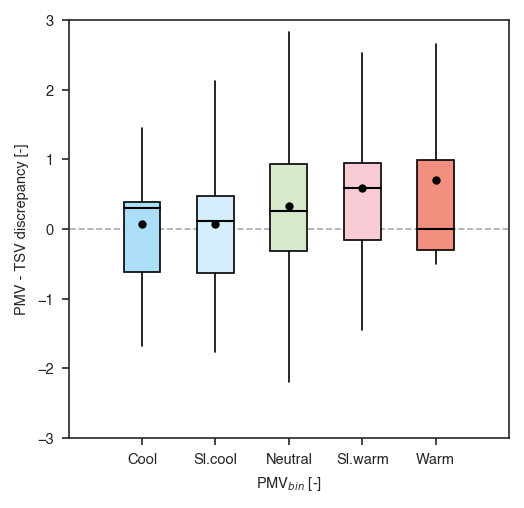

In [277]:
# BINNED PMV - DISCREPANCY

width=89*mm

plt.figure(figsize=(width, width), dpi=150)

markercolor = 'black'

medianprops = dict(color='black', linewidth=1)
meanprops = dict(markeredgecolor=markercolor,markerfacecolor=markercolor, marker='o', markersize=3, label='mean_marker')
whiskerprops = dict(color='black', linewidth=0.8)
boxprops = dict(color='black', linewidth=0.8)

facecolors = {
    '-2': '#acdef7',
    '-1': '#d4eefb',
    '0': '#d9eacc',
    '1': '#f9cbd4',
    '2': '#f2907f',
}

ax = field_data.boxplot(column='discrepancy',by='pmv_7point', 
            showfliers=False, 
            showcaps=False, 
            showmeans=True, meanprops=meanprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            boxprops=boxprops,
            grid=False,
            patch_artist=True,
            ax = plt.gca(),
            )

fig = ax.get_figure().suptitle('')

for box, color in zip(ax.artists, facecolors.values()):
    box.set_facecolor(color)


x = [-1, 10]
y = [0.0,0.0]

plt.plot(x,y, linewidth=0.8, color='darkgrey', linestyle='--')


plt.title(label='')


plt.xlabel("PMV$_{bin}$ [-]", fontsize=uni_fontsize)
plt.ylabel('PMV - TSV discrepancy [-]', size=uni_fontsize, **hfont)
plt.yticks(ticks=range(-3,4,1), fontsize=uni_fontsize, **hfont)

plt.xticks(ticks=range(1,6,1), labels=['Cool','Sl.cool','Neutral','Sl.warm','Warm'],rotation=0, fontsize=uni_fontsize)
plt.xlim((0,6))
plt.yticks(ticks=range(-3,4,1), fontsize=uni_fontsize)
plt.ylim(-3,3)

# plt.legend(handles ='mean_marker',labels=['mean'] )

# ! This is 1.5 IQR

plt.tight_layout()

#plt.savefig('reports/figures/pmv-discrepancy-boxplots.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()



### target - location

## A.4 PERSONAL

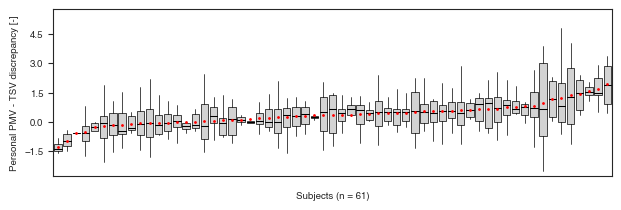

In [278]:
# PERSONAL DISCREPANCY BOXPLOTS

width = 183*mm

plt.figure(figsize=(width,0.3*width))

# subset = field_data.loc[field_data['tr'].between(23,24)]

medianprops = dict(color='black', linewidth=0.75)
meanprops = dict(markeredgecolor='red',markerfacecolor='red', marker='o', markersize=1)
boxprops = dict(linewidth=0.5, edgecolor='black')
whiskerprops = dict(linewidth=0.5, color='black')

grouped = field_data.loc[:,['subject_id', 'discrepancy']] \
    .groupby(['subject_id']) \
    .mean() \
    .sort_values(by='discrepancy')

ax = sns.boxplot(x=field_data.subject_id, y=field_data.discrepancy,
            order=grouped.index,
            color='lightgrey',
            showfliers=False,
            showcaps=False,
            showmeans=True,
            boxprops=boxprops,
            meanprops=meanprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set_ylabel('Personal PMV - TSV discrepancy [-]', fontsize=7)
ax.set_xlabel('Subjects (n = 61)', fontsize=7)
ax.tick_params(bottom=False)
ax.set_ylim(-2.75,5.75)
ax.set_yticks(np.arange(-1.5,6,1.5))

ax.yaxis.set_tick_params(labelsize=7)

# plt.savefig('reports/figures/pers-discr-ordered_boxplts.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()

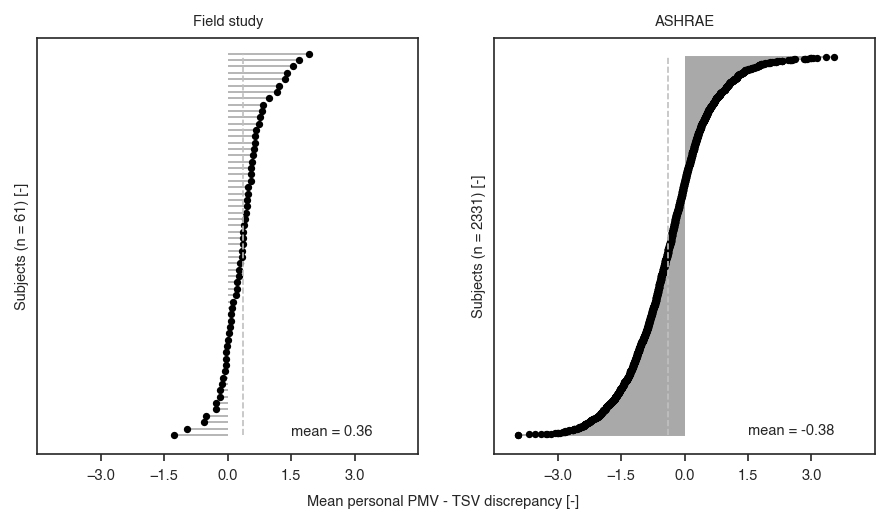

In [279]:
width = 183*mm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, 0.5*width), dpi=150, sharex=True)
ax1.tick_params(axis='both', which='major', labelsize=uni_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=uni_fontsize)

#df 1 - Field data
df_1 = field_data.groupby(['personal_mean_discrepancy'])['subject_id'].mean().reset_index(name='id')
mean_discrepancy = round(df_1['personal_mean_discrepancy'].mean(),2)

# Reorder it based on the personal_mean_discrepancy
df_1 = df_1.sort_values(by='personal_mean_discrepancy')
my_range=range(1,len(df_1.index)+1)

ax1.set_title('Field study', fontsize=uni_fontsize)
ax1.hlines(y=my_range, xmin=0, xmax=df_1['personal_mean_discrepancy'], color='darkgrey', linewidth=0.8)
ax1.plot(df_1['personal_mean_discrepancy'], my_range,"o", markersize=2.5, color='black')
y1=[1,len(df_1)]
x1=[mean_discrepancy,mean_discrepancy]
ax1.set_yticks([])
ax1.set_ylim(-2,63.5)
ax1.plot(x1,y1, linewidth=0.8, color='silver', linestyle='--')
ax1.set_ylabel('Subjects (n = 61) [-]',fontsize=uni_fontsize, **hfont)
ax1.annotate(f"mean = {mean_discrepancy}",(1.5,1),size=uni_fontsize, **hfont)



#df 2 - ASHRAE
df_2 = ashrae_subset.groupby(['personal_mean_discrepancy'])['subject_id'].mean().reset_index(name='subject_id')
mean_discrepancy = round(df_2['personal_mean_discrepancy'].mean(),2)

# Reorder it based on the personal_mean_discrepancy
df_2 = df_2.sort_values(by='personal_mean_discrepancy')
my_range=range(1,len(df_2.index)+1)

ax2.set_title('ASHRAE', fontsize=uni_fontsize)
ax2.hlines(y=my_range, xmin=0, xmax=df_2['personal_mean_discrepancy'], color='darkgrey', linewidth=0.8)
ax2.plot(df_2['personal_mean_discrepancy'], my_range,"o", markersize=2.5, color='black')
y2=[0,len(df_2)+2]
x2=[mean_discrepancy,mean_discrepancy]
ax2.set_yticks([])
ax2.plot(x2,y2, linewidth=0.8, color='silver', linestyle='--')
ax2.set_ylabel('Subjects (n = 2331) [-]',fontsize=uni_fontsize, **hfont)
ax2.set_xticks([-3,-1.5,0,1.5,3])
ax2.set_xlim(-4.5,4.5)
ax2.annotate(f"mean = {mean_discrepancy}",(1.5,1),size=uni_fontsize, **hfont)

fig.supxlabel('Mean personal PMV - TSV discrepancy [-]', fontsize=uni_fontsize, **hfont)

# plt.savefig('reports/figures/personal-discrepancy-mean-distribution.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()

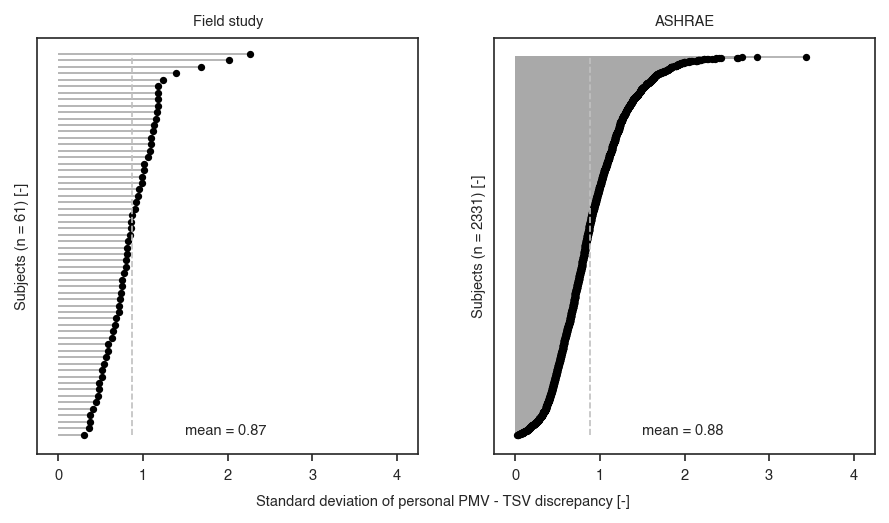

In [280]:
width = 183*mm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, 0.5*width), dpi=150, sharex=True)
ax1.tick_params(axis='both', which='major', labelsize=uni_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=uni_fontsize)

#df 1 - Field data
df_1 = field_data.groupby(['personal_discrepancy_std'])['subject_id'].mean().reset_index(name='id')
mean_discrepancy = round(df_1['personal_discrepancy_std'].mean(),2)

# Reorder it based on the personal_discrepancy_variance
df_1 = df_1.sort_values(by='personal_discrepancy_std')
my_range=range(1,len(df_1.index)+1)

ax1.set_title('Field study', fontsize=uni_fontsize)
ax1.hlines(y=my_range, xmin=0, xmax=df_1['personal_discrepancy_std'], color='darkgrey', linewidth=0.8)
ax1.plot(df_1['personal_discrepancy_std'], my_range,"o", markersize=2.5, color='black')
y1=[1,len(df_1)]
x1=[mean_discrepancy,mean_discrepancy]
ax1.set_yticks([])
ax1.set_ylim(-2,62.5)
ax1.plot(x1,y1, linewidth=0.8, color='silver', linestyle='--')
ax1.set_ylabel('Subjects (n = 61) [-]',fontsize=uni_fontsize, **hfont)
ax1.annotate(f"mean = {mean_discrepancy}",(1.5,1),size=uni_fontsize, **hfont)



#df 2 - ASHRAE
df_2 = ashrae_subset.groupby(['personal_discrepancy_std'])['subject_id'].mean().reset_index(name='subject_id')
mean_discrepancy = round(df_2['personal_discrepancy_std'].mean(),2)

# Reorder it based on the personal_discrepancy_variance
df_2 = df_2.sort_values(by='personal_discrepancy_std')
my_range=range(1,len(df_2.index)+1)

ax2.set_title('ASHRAE', fontsize=uni_fontsize)
ax2.hlines(y=my_range, xmin=0, xmax=df_2['personal_discrepancy_std'], color='darkgrey', linewidth=0.8)
ax2.plot(df_2['personal_discrepancy_std'], my_range,"o", markersize=2.5, color='black')
y2=[0,len(df_2)+2]
x2=[mean_discrepancy,mean_discrepancy]
ax2.set_yticks([])
ax2.plot(x2,y2, linewidth=0.8, color='silver', linestyle='--')
ax2.set_ylabel('Subjects (n = 2331) [-]',fontsize=uni_fontsize, **hfont)
ax2.set_xticks(range(0,5,1))
ax1.set_xlim(-0.25,4.25)
ax2.annotate(f"mean = {mean_discrepancy}",(1.5,1),size=uni_fontsize, **hfont)

fig.supxlabel('Standard deviation of personal PMV - TSV discrepancy [-]', fontsize=uni_fontsize, **hfont)

# plt.savefig('reports/figures/personal-discrepancy-variance-distribution.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()

## B. OFF-BOARDING

In [281]:
metadata.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,43.0,21.000000,12.556539,0.0,10.50,21.0,31.50,42.0
subject_id,43.0,69.116279,55.929466,1.0,12.00,102.0,121.50,142.0
acclimatisation,43.0,2.604651,0.929402,1.0,2.00,3.0,3.00,4.0
height,43.0,169.023256,10.523191,150.0,160.50,170.0,175.50,200.0
weight,43.0,66.697674,11.572823,48.0,58.50,65.0,72.50,95.0
bmi,43.0,23.330233,3.424529,17.3,21.45,22.5,24.20,34.1
productivity,43.0,-0.653488,1.389647,-2.5,-1.75,-0.5,0.50,2.0
activity,43.0,1.395349,1.382536,-2.0,1.00,2.0,2.00,3.0
exercise,43.0,2.558140,1.097667,0.0,2.00,3.0,3.00,4.0
health,43.0,0.302326,0.438335,0.0,0.00,0.0,0.75,1.0


/Users/tobi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


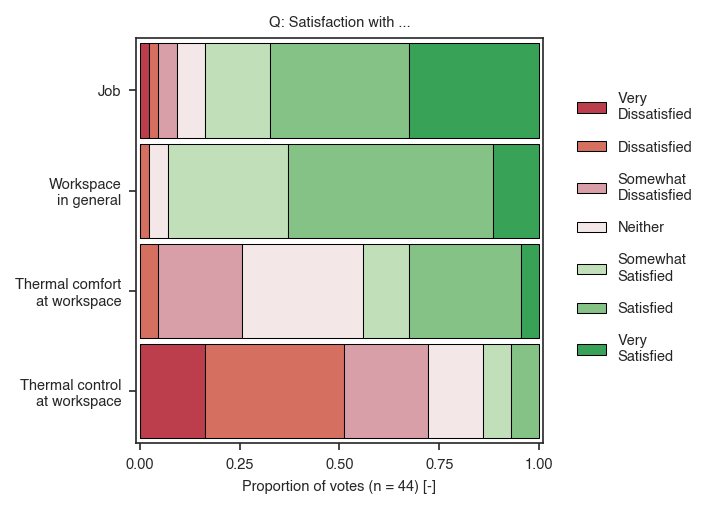

In [282]:
# SATISFACTION SCORES; was later replicated in R


subset = metadata[['workspace_satisfaction', 'control_satisfaction','tc_interference','job_satisfaction']]

subset.job_satisfaction = subset['job_satisfaction'] - 4

control = subset.control_satisfaction.value_counts().rename_axis('value').to_frame()
workspace =  subset.workspace_satisfaction.value_counts().rename_axis('value').to_frame()
interference =  subset.tc_interference.value_counts().rename_axis('value').to_frame()
job = subset.job_satisfaction.value_counts().rename_axis('value').to_frame()

# subset.workspace_satisfaction.value_counts()
new = control.merge(interference, on='value', how='outer').fillna(0).merge(workspace, on='value', how='outer').fillna(0).merge(job, on='value', how='outer').fillna(0).T

new = new.reindex(sorted(new.columns), axis=1)
new = (( new / len(metadata) ) * 100)


width = 89*mm

plt.figure(figsize=(width,width), dpi=150)

fig = new.plot(
    kind = 'barh',
    edgecolor = 'black',
    linewidth=0.5,
    width = 0.94,
    stacked = True,
    mark_right = True,
    color = cbe_satisfaction_colors,
    ax = plt.gca())

satisfaction_labels = ['Very\nDissatisfied','Dissatisfied','Somewhat\nDissatisfied','Neither','Somewhat\nSatisfied','Satisfied','Very\nSatisfied']

plt.legend(bbox_to_anchor=(1.05, 0.9),
            labels=satisfaction_labels, 
            frameon=False, 
            fontsize=uni_fontsize,
            labelspacing=1.25)

plt.xlabel('Proportion of votes (n = 44) [-]', fontsize=uni_fontsize)

plt.ylim(-0.52,3.52)
plt.xlim((-1,101))

plt.title('Q: Satisfaction with ...',fontsize=uni_fontsize, **hfont)

plt.xticks(ticks=[0,25,50,75,100], labels=['0.00','0.25','0.50','0.75','1.00'],fontsize=uni_fontsize, **hfont)
plt.yticks(ticks=[0,1,2,3],labels=['Thermal control\nat workspace','Thermal comfort\nat workspace','Workspace\nin general','Job'],fontsize=uni_fontsize, **hfont)

# plt.savefig('reports/figures/satisfaction-scores.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()

_________________________________________________

**ADDITIONAL WORK: SPATIAL VARIETY MONITORING DATA**

In [283]:
monitoring = pd.read_pickle('data/raw/monitoring.pkl')
survey = pd.read_pickle('data/raw/survey.pkl')

In [284]:
# dict for useful data
# int represents week, list contains boxes that can be used

data_dict = {

1: ['box1', 'box2', 'box3', 'box4'],
2: ['box1', 'box2', 'box3', 'box4'],
3: ['box1', 'box2', 'box3', 'box4', 'box10', 'box8'],
4: ['box1', 'box3', 'box4'],
6: ['box4', 'box3', 'box7', 'box10', 'box9', 'box8'],
8: ['box1', 'box2', 'box12', 'box3']

}


In [285]:
data = monitoring.dropna()


In [286]:
def heterogeneity(data:df, dict:dict, variable:str):
    """Function that merges measurement based on timestamp and week

    Args:
        data (df): Input of raw monitoring data
        dict (dict): Dictionary of climateBOX unit in one room
        variable (str): Parameter to analyse

    Returns:
        dict: Dictionary with 'Week':'Boxes' pairs
    """

    import pythermalcomfort as tc


#-----------------
# Use dictionary to filter the relevant data

    frames_dict = {}
    frames = []

    for key in dict:

        frames = []
        
        for i in range(0,len(dict[key])):

            iter_data = data.loc[(data['week'] == key) & (data['boxID'] == dict[key][i])]
            new_data = iter_data[['time','boxID','week','ta','tg','rh','vel']]
            frames.append(new_data)
        
        frames_dict[key] = frames


#-----------------
# Group data in 5min intervals

    updated_frames_dict = {}
    

    for key in frames_dict:

        updated_frames = []

        for df in frames_dict[key]:

            id = df['boxID'].mode()[0]

            df.loc[:,'timestamp'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
            df = df.set_index(['timestamp'])

            # calculate comfort here
            df.loc[:,'set'] = df.apply(lambda row : tc.models.set_tmp(
                row['ta'],
                row['tg'],
                row['vel'],
                row['rh'],
                1.1 ,
                0.8,
                ),
                axis=1)

            #

            df[id] = df.groupby(df.index.floor('5T'))[variable].transform('mean')
            df.index = df.index.floor('5T')

            df = df[~df.index.duplicated(keep='first')].drop(columns=['week','boxID','time','ta','tg','rh','vel','set'])
            updated_frames.append(df)
        
        updated_frames_dict[key] = updated_frames


#-----------------
# Concatenate relevant columns

    result_frames_dict = {}

    for key in updated_frames_dict:
        
        base = updated_frames_dict[key][0]
        length = len(updated_frames_dict[key])

        for i in range(1,length):

            base = pd.concat([base, updated_frames_dict[key][i]], axis=1)
        
        result_frames_dict[key] = base.dropna()

            
    return result_frames_dict

/Users/tobi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


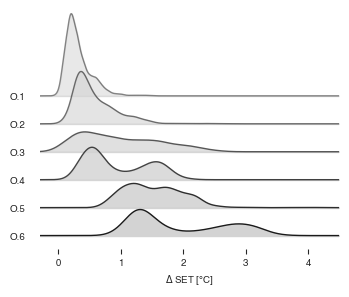

In [287]:
accumulated_data = heterogeneity(data, data_dict, 'set')

width = 89*mm

numbers = []

for key in accumulated_data:

    #? Spatial heterogeneity defined as the difference between sensor positions at a time

    df = accumulated_data[key].reset_index()
    df.loc[:,'diff'] = df.max(axis=1,numeric_only=True) - df.min(axis=1, numeric_only=True)

    numbers.append(df['diff'])

    

myorder = [0, 1, 3, 5, 4, 2]
numbers = [numbers[i] for i in myorder]

data_per_building = pd.concat(numbers, axis=1, keys=['O.1','O.2','O.3','O.4','O.5','O.6'])



# Maybe work with IQR here?

from joypy import joyplot
from matplotlib import cm

plt.rcParams.update({'font.size': 7})

joyplot(data_per_building, kind='kde', color='lightgrey',fade = True, overlap=1.5, linewidth=1, figsize=(width,0.8*width), x_range=[-0.3,4.5]) # x_range=(-0.1,3)


# plt.title('Spatial heterogeneity')
plt.xlabel(r'$\Delta$' + ' SET [°C]', fontsize=uni_fontsize, **hfont)


# plt.savefig('reports/figures/heterogeneity.png',dpi=300, bbox_inches = 'tight', transparent=True)

plt.show()


In [288]:
meta = pd.read_pickle('data/interim/field-meta.pkl').dropna()

meta.columns


Index(['Unnamed: 0_x', 'time', 'week', 'boxID', 'season', 'subject_id',
       'building_id', 'gender', 'age_group', 'thermal_sensation',
       'thermal_preference', 'thermal_acceptability', 'clo', 'met', 'air_con',
       'blind_curtain', 'window', 'door', 'heater', 'fan_portable', 'ta',
       'vel', 'rh', 'tg', 't_out_min', 't_out_max', 'rain_out', 'sunshine_out',
       'rh_out_9am', 't_out_mean', 'rh_out_mean', 'running_mean_t_out',
       'utci_am', 'utci_pm', 'tr', 'top', 'vel_r', 'pmv', 'adaptive_tmp_cmf',
       'adaptive_acceptability_80', 'set', 'city', 'country', 'climate',
       'cooling_type', 'building_type', 'pmv_7point', 'discrepancy',
       'thermal_sensation_3point', 'pmv_3point', 'age',
       'personal_mean_discrepancy', 'personal_discrepancy_variance',
       'personal_discrepancy_std', 'personal_mean_clo', 'day_hour', 'year',
       'Unnamed: 0_y', 'acclimatisation', 'origin', 'height', 'weight', 'bmi',
       'productivity', 'activity', 'exercise', 'health', 

In [289]:
meta.head(10)

,Unnamed: 0_x,time,week,boxID,season,subject_id,building_id,gender,age_group,thermal_sensation,...,metabolism,thermal_sensitivity,ac_usage,hybrid_work,workspace_satisfaction,tc_interference,control_satisfaction,job_satisfaction,life_satisfaction_score,metadata
0,0,2021-10-11 11:34:00,1,4,winter,101,8,female,25 - 34,0,...,0.0,heat,1.0,1.0,1.0,1.0,0.0,5.0,3.1,True
1,1,2021-10-11 11:36:00,1,1,winter,1,8,female,35 - 44,0,...,0.0,heat,0.0,1.0,2.0,1.0,-2.0,7.0,5.0,True
2,2,2021-10-11 11:36:00,1,7,winter,123,4,female,25 - 34,-1,...,0.0,heat/cold,0.0,-1.0,0.0,3.0,0.0,7.0,5.1,True
4,4,2021-10-11 11:53:00,1,3,winter,102,8,female,25 - 34,-1,...,0.0,heat/cold,1.0,1.0,2.0,1.0,-3.0,7.0,4.7,True
6,6,2021-10-11 12:17:00,1,9,winter,103,7,female,25 - 34,-3,...,0.0,cold,1.0,1.0,2.0,3.0,-2.0,6.0,4.0,True
7,7,2021-10-11 13:14:00,1,4,winter,101,8,female,25 - 34,0,...,0.0,heat,1.0,1.0,1.0,1.0,0.0,5.0,3.1,True
10,10,2021-10-11 14:01:00,1,3,winter,102,8,female,25 - 34,-1,...,0.0,heat/cold,1.0,1.0,2.0,1.0,-3.0,7.0,4.7,True
11,11,2021-10-11 14:30:00,1,9,winter,103,7,female,25 - 34,-3,...,0.0,cold,1.0,1.0,2.0,3.0,-2.0,6.0,4.0,True
13,13,2021-10-11 15:26:00,1,2,winter,2,8,female,35 - 44,-1,...,1.0,heat/cold,3.0,1.0,2.0,0.0,-2.0,6.0,5.0,True
14,14,2021-10-11 15:35:00,1,4,winter,101,8,female,25 - 34,-1,...,0.0,heat,1.0,1.0,1.0,1.0,0.0,5.0,3.1,True


In [290]:
subject_based = meta.drop_duplicates(subset='subject_id', keep="first").drop(columns = ['building_id','gender',
        'age_group', 'thermal_sensation', 'thermal_preference',
       'thermal_acceptability', 'clo', 'met', 'air_con', 'blind_curtain',
       'window', 'door', 'heater', 'fan_portable', 'ta', 'vel', 'rh', 'tg',
       't_out_min', 't_out_max', 'rain_out', 'sunshine_out', 'rh_out_9am',
       't_out_mean', 'rh_out_mean', 'running_mean_t_out', 'utci_am', 'utci_pm',
       'tr', 'top', 'vel_r', 'pmv', 'adaptive_tmp_cmf',
       'adaptive_acceptability_80', 'set', 'city', 'country', 'climate',
       'cooling_type', 'building_type', 'pmv_7point', 'discrepancy',
       'thermal_sensation_3point', 'pmv_3point', 'time', 'week', 'boxID', 'season'])

# subject_based.to_csv('data/interm/subject-based.csv')

In [291]:

subject_based['origin'] = ["australia" if x == "australia"  else "rest" for x in subject_based['origin']]
subject_based['health'] = ["False" if x == 0  else "True" for x in subject_based['health']]
subject_based['exercise'] = ["Little" if x <= 2  else "More" for x in subject_based['exercise']]
subject_based['height'] = ["Smaller" if x < 170  else "Taller" for x in subject_based['height']]
subject_based['personal_mean_clo'] = ["Light" if x < 0.65  else "Heavy" for x in subject_based['personal_mean_clo']]


In [292]:
from scipy import stats

def box_and_whisker(data, title, ylabel, xticklabels):
    """
    Create a box-and-whisker plot with significance bars.
    """

    width = 89*mm

    plt.figure(figsize=(width,width), dpi=150)

    ax = plt.axes()
    bp = ax.boxplot(data, widths=0.6, patch_artist=True, showfliers=False)
    # Graph title
    ax.set_title(title, fontsize=7)
    # Label y-axis
    ax.set_ylabel(ylabel, fontsize=7)
    ax.set_ylim(-0.75,1.75)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels, fontsize=7)
    ax.set_yticklabels([-1.0,-0.5,0.0,0.5,1,1.5],fontsize=7)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    # xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    # ax.set_xticks(xticks, minor=True)
    # # Clean up the appearance
    # ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel')
    for patch, color in zip(bp['boxes'], colors):
        # patch.set_facecolor(color)
        patch.set_facecolor('lightgrey')

    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    # Check for statistical significance
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([c, p])

    # Get info about y-axis
    bottom, top = 0,1.4#ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k', size=7)

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

    # Annotate sample size below each box
    for i, dataset in enumerate(data):
        sample_size = len(dataset)
        ax.text(i + 1, bottom, fr'n = {sample_size}', ha='center', size=7)

    # plt.savefig('reports/figures/' + title + '-plot.png',dpi=300, bbox_inches = 'tight', transparent=True)

    plt.show()

/var/folders/1w/rd04svb56878ny53bl_ftyz40000gn/T/ipykernel_34370/4160333871.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-1.0,-0.5,0.0,0.5,1,1.5],fontsize=7)


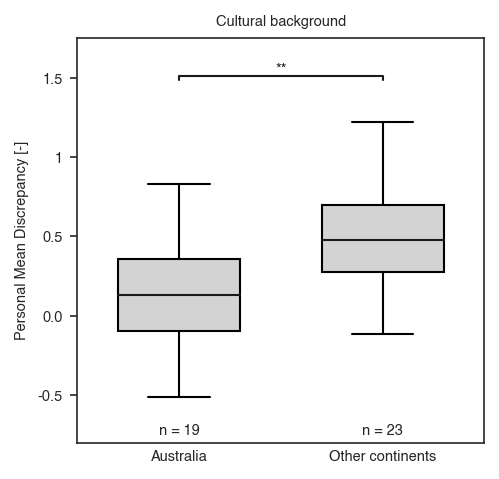

In [293]:
data = subject_based
variable = 'origin'

g1 = data.loc[data[variable] == 'australia']['personal_mean_discrepancy']
g2 = data.loc[data[variable] == 'rest']['personal_mean_discrepancy']

data = [g1,g2]
title = 'Cultural background'
ylabel = 'Personal Mean Discrepancy [-]'
xticklabels = ['Australia', 'Other continents']
plot1 = box_and_whisker(data, title, ylabel, xticklabels)

/var/folders/1w/rd04svb56878ny53bl_ftyz40000gn/T/ipykernel_34370/4160333871.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-1.0,-0.5,0.0,0.5,1,1.5],fontsize=7)


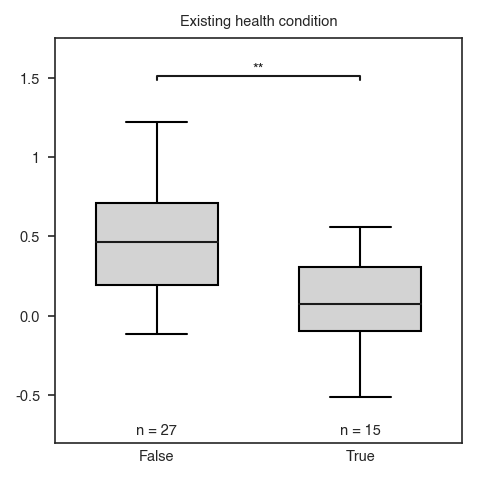

In [294]:
data = subject_based

variable = 'health'

g3 = data.loc[data[variable] == 'False']['personal_mean_discrepancy']
g4 = data.loc[data[variable] == 'True']['personal_mean_discrepancy']

data = [g3,g4]
title = 'Existing health condition'
ylabel = ''
xticklabels = ['False', 'True']
plot2 = box_and_whisker(data, title, ylabel, xticklabels)

/var/folders/1w/rd04svb56878ny53bl_ftyz40000gn/T/ipykernel_34370/4160333871.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-1.0,-0.5,0.0,0.5,1,1.5],fontsize=7)


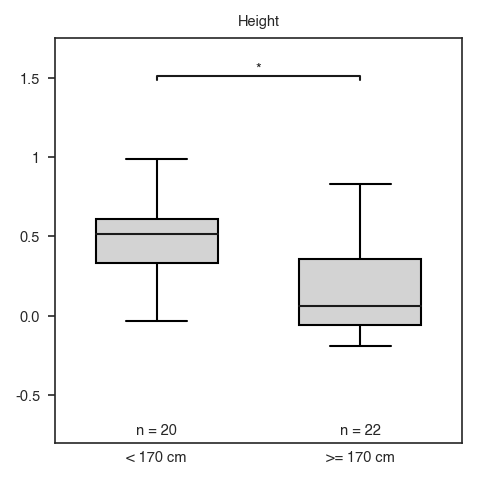

In [295]:
data = subject_based

variable = 'height'

g5 = data.loc[data[variable] == 'Smaller']['personal_mean_discrepancy']
g6 = data.loc[data[variable] == 'Taller']['personal_mean_discrepancy']

data = [g5,g6]
title = 'Height'
ylabel = ''
xticklabels = ['< 170 cm', '>= 170 cm']
plot3 = box_and_whisker(data, title, ylabel, xticklabels)

/var/folders/1w/rd04svb56878ny53bl_ftyz40000gn/T/ipykernel_34370/4160333871.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-1.0,-0.5,0.0,0.5,1,1.5],fontsize=7)


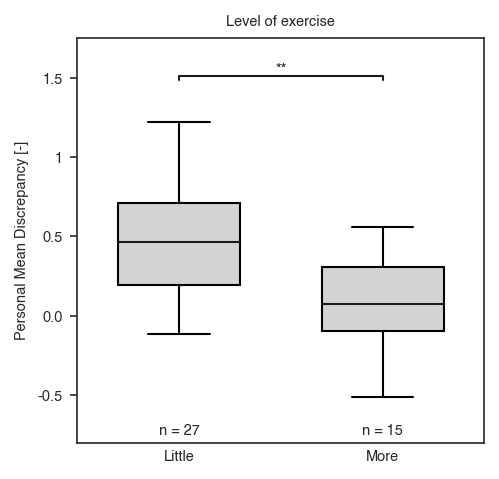

In [296]:
data = subject_based

variable = 'exercise'

g7 = data.loc[data[variable] == 'Little']['personal_mean_discrepancy']
g8 = data.loc[data[variable] == 'More']['personal_mean_discrepancy']

data = [g3,g4]
title = 'Level of exercise'
ylabel = 'Personal Mean Discrepancy [-]'
xticklabels = ['Little', 'More']
plot4 = box_and_whisker(data, title, ylabel, xticklabels)

/var/folders/1w/rd04svb56878ny53bl_ftyz40000gn/T/ipykernel_34370/4160333871.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-1.0,-0.5,0.0,0.5,1,1.5],fontsize=7)


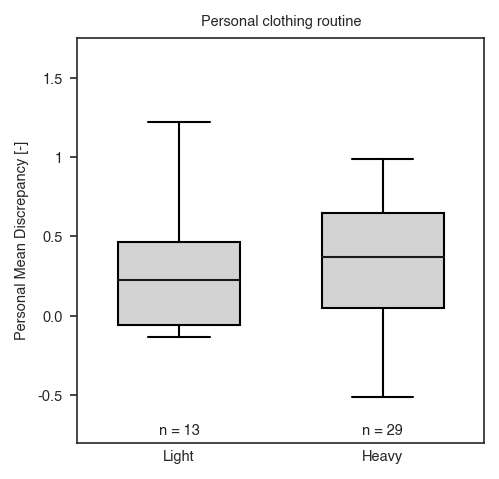

In [297]:
data = subject_based

variable = 'personal_mean_clo'

g9 = data.loc[data[variable] == 'Light']['personal_mean_discrepancy']
g10 = data.loc[data[variable] == 'Heavy']['personal_mean_discrepancy']

data = [g9,g10]
title = 'Personal clothing routine'
ylabel = 'Personal Mean Discrepancy [-]'
xticklabels = ['Light', 'Heavy']
plot4 = box_and_whisker(data, title, ylabel, xticklabels)